In [103]:
# Importando bibliotecas válidas para a análise
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve

In [104]:
df = pd.read_csv('csv/game.csv')
df = df[df['season_type'].isin(['Regular Season', 'Playoffs'])]
df = df[df['game_date'] >= '2014-01-01']

In [105]:
#adicona ao df uma variavel binaria que diz se o time daa casa ganhou ou não
df['home_win'] = df['wl_home'].apply(lambda x: 1 if x == 'W' else 0)

In [106]:
df.sort_values(by='game_date', inplace=True)

In [107]:
#Eficiencia dos Arremessos (Effective Field Goal %) ---
# Leva em conta que um arremesso de 3 pontos vale mais.
# Fórmula: (FGM + 0.5 * FG3M) / FGA
#0.5 é pq 3 pontos valem 1.5 vezes mais que 2 pontos.
df['efg_pct_home'] = (df['fgm_home'] + 0.5 * df['fg3m_home']) / df['fga_home']
df['efg_pct_away'] = (df['fgm_away'] + 0.5 * df['fg3m_away']) / df['fga_away']

#Cuidar da Bola (Turnover Rate) ---
# Usamos uma aproximação comum para o número de posses de bola.
# Fórmula: TOV / (FGA + 0.44 * FTA + TOV)
#ter um numero de turnovers maior que o do adversario é pior pois significa que o time está perdendo a posse de bola com mais frequência.
possessions_home = df['fga_home'] + 0.44 * df['fta_home'] + df['tov_home']
possessions_away = df['fga_away'] + 0.44 * df['fta_away'] + df['tov_away']
df['tov_rate_home'] = df['tov_home'] / possessions_home
df['tov_rate_away'] = df['tov_away'] / possessions_away

#Rebotes Ofensivos (Offensive Rebound %) ---
# Qual a porcentagem de seus próprios arremessos errados um time recupera?
# Fórmula: OREB / (OREB + DREB do Oponente)
df['oreb_pct_home'] = df['oreb_home'] / (df['oreb_home'] + df['dreb_away'])
df['oreb_pct_away'] = df['oreb_away'] / (df['oreb_away'] + df['dreb_home'])

#Chegar na Linha de Lance Livre (Free Throw Rate) ---
# Com que frequência um time vai para a linha de lance livre em relação aos seus arremessos.
# Fórmula: FTM / FGA
df['ft_rate_home'] = df['ftm_home'] / df['fga_home']
df['ft_rate_away'] = df['ftm_away'] / df['fga_away']

# Vamos tratar possíveis divisões por zero, caso existam, preenchendo com 0
df.fillna(0, inplace=True)

print("Novas colunas com métricas avançadas criadas:")
print(df[['efg_pct_home', 'tov_rate_home', 'oreb_pct_home', 'ft_rate_home']].head())

Novas colunas com métricas avançadas criadas:
       efg_pct_home  tov_rate_home  oreb_pct_home  ft_rate_home
52624      0.403409       0.170557       0.319149      0.079545
52625      0.480769       0.161720       0.236842      0.256410
52626      0.607595       0.137112       0.294118      0.354430
52627      0.423077       0.116279       0.277778      0.274725
52628      0.617647       0.143678       0.205128      0.082353


In [108]:
# Lista das novas métricas que criamos
advanced_stats_cols = ['efg_pct', 'tov_rate', 'oreb_pct', 'ft_rate']

# Unificar os dados para facilitar o cálculo (mesma lógica de antes)
home_stats = df[['game_date', 'team_id_home', 'season_id'] + [f'{col}_home' for col in advanced_stats_cols]]
home_stats.columns = ['game_date', 'team_id', 'season_id'] + advanced_stats_cols

away_stats = df[['game_date', 'team_id_away', 'season_id'] + [f'{col}_away' for col in advanced_stats_cols]]
away_stats.columns = ['game_date', 'team_id', 'season_id'] + advanced_stats_cols

team_stats_df = pd.concat([home_stats, away_stats])
team_stats_df.sort_values(['team_id', 'game_date'], inplace=True)

# Calcular a média cumulativa (expanding mean) para as novas métricas
#a média cumulativa é a média até aquele momento especifico da temporada.
cumulative_stats = team_stats_df.groupby(['team_id', 'season_id'])[advanced_stats_cols].apply(
    lambda x: x.expanding().mean().shift(1)
)
cumulative_stats.columns = [f'{col}_avg' for col in advanced_stats_cols]

# Juntando as médias de volta ao dataframe original
# (Esta parte do código é idêntica à anterior, apenas aplicada às novas colunas)
team_stats_df_reset = team_stats_df.reset_index()
cumulative_stats_reset = cumulative_stats.reset_index()
full_stats = pd.merge(team_stats_df_reset, cumulative_stats_reset, left_index=True, right_index=True, suffixes=('', '_y'))

df = pd.merge(df, full_stats[['game_date', 'team_id'] + list(cumulative_stats.columns)], left_on=['game_date', 'team_id_home'], right_on=['game_date', 'team_id'], how='left')
df.rename(columns={f'{col}_avg': f'{col}_home_avg' for col in advanced_stats_cols}, inplace=True)
df.drop('team_id', axis=1, inplace=True)

df = pd.merge(df, full_stats[['game_date', 'team_id'] + list(cumulative_stats.columns)], left_on=['game_date', 'team_id_away'], right_on=['game_date', 'team_id'], how='left')
df.rename(columns={f'{col}_avg': f'{col}_away_avg' for col in advanced_stats_cols}, inplace=True)
df.drop('team_id', axis=1, inplace=True)

# Lidar com os primeiros jogos da temporada que não terão médias
df.dropna(inplace=True)

In [109]:
# Criar as features diferenciais finais
for col in advanced_stats_cols:
    df[f'diff_{col}_avg'] = df[f'{col}_home_avg'] - df[f'{col}_away_avg']

# Definir a lista final de colunas de features para o modelo
final_feature_columns = [f'diff_{col}_avg' for col in advanced_stats_cols]

print("Features finais criadas e prontas para o modelo:")
print(df[final_feature_columns].head())

Features finais criadas e prontas para o modelo:
    diff_efg_pct_avg  diff_tov_rate_avg  diff_oreb_pct_avg  diff_ft_rate_avg
15         -0.144317           0.023027          -0.015476          0.013623
16         -0.194570           0.001783           0.073942          0.186878
17         -0.071488          -0.016277          -0.135266          0.187769
18         -0.077360           0.008837           0.082307         -0.176865
21         -0.062893           0.065151          -0.127157         -0.026668


In [110]:
features_finais = ['diff_efg_pct_avg', 'diff_tov_rate_avg', 'diff_oreb_pct_avg', 'diff_ft_rate_avg']

In [111]:
x = df[features_finais]
y = df['home_win']
# Dividir os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [112]:
#escalonamento de features: coloca todas na mesma escala
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [113]:
#treinar o modelo de regressao logistica
model = LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train)

print("Modelo treinado")

Modelo treinado


In [114]:
y_pred = model.predict(x_test_scaled)


In [115]:
#calcula da acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.4f} (~{accuracy: .2f}%)")

Acurácia do modelo: 0.6329 (~ 0.63%)



Relatório de Classificação:
                 precision    recall  f1-score   support

Visitante Vence       0.60      0.36      0.45       996
     Casa Vence       0.64      0.83      0.72      1390

       accuracy                           0.63      2386
      macro avg       0.62      0.59      0.59      2386
   weighted avg       0.63      0.63      0.61      2386


Matriz de Confusão:


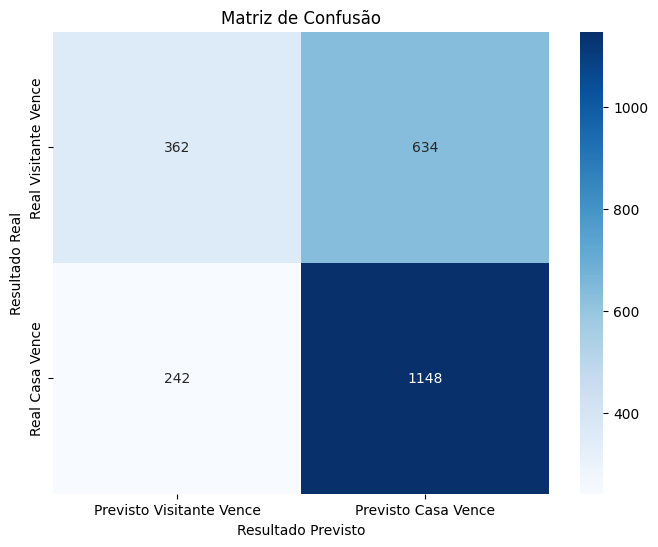

In [116]:
# Relatório de Classificação Completo
print("\nRelatório de Classificação:")
# 'Casa Vence' é a classe 1, 'Visitante Vence' é a classe 0
print(classification_report(y_test, y_pred, target_names=['Visitante Vence', 'Casa Vence']))

# Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Visitante Vence', 'Previsto Casa Vence'],
            yticklabels=['Real Visitante Vence', 'Real Casa Vence'])
plt.ylabel('Resultado Real')
plt.xlabel('Resultado Previsto')
plt.title('Matriz de Confusão')
plt.show()